<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/CV_Gan/gan_hw_cond.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 15
config.noise_size = 100
config.print_freq = 500

### Создаем dataloader

In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist",
                                          train=True,
                                          transform=torchvision.transforms.ToTensor(),
                                          download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11728453.73it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212353.88it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3815029.61it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16935119.21it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)
len(dataloader)

3750

In [ ]:
image, label = next(iter(dataloader))
image.size(), label

(torch.Size([16, 1, 28, 28]),
 tensor([2, 3, 9, 2, 6, 3, 2, 7, 5, 6, 0, 4, 0, 3, 7, 0]))

### Создаем модель GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, nun_classes, embedding_dim):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(nun_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(config.noise_size + embedding_dim, 256), # add condition
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 28*28),
            nn.Sigmoid() # if remove then criterion = nn.BCEWithLogitsLoss()
            )

    def forward(self,  x, label):
        #embed label
        label = self.embedding(label)
        #concatenate image vector and label
        input = torch.cat([x, label], 1) # add condition

        return self.model(input)

class Discriminator(nn.Module):
    def __init__(self, nun_classes, embedding_dim):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(nun_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(28*28 + embedding_dim, 256), # add condition
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid() # if remove then criterion = nn.BCEWithLogitsLoss()
            )
    def forward(self, x, label):
        #embed label
        label = self.embedding(label)
        #concatenate image vector and label
        input = torch.cat([x, label], 1) # add condition

        return self.model(input)

In [ ]:
NUM_CLASSES = len(set(train.targets.numpy()))
EMB_DIM = 32
generator = Generator(NUM_CLASSES, EMB_DIM)
discriminator = Discriminator(NUM_CLASSES, EMB_DIM)

### Оптимизатор и функция потерь

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()

### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [ ]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).to(DEVICE))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).to(DEVICE).normal_(0, 1))
fixed_classes = torch.randint(0, NUM_CLASSES, (config.batch_size,))
label = Variable(torch.FloatTensor(config.batch_size).to(DEVICE))
real_label = 1
fake_label = 0

### Plot condition generation

In [ ]:
IMG_ROWS,IMG_COLS = 28, 28

# Create a dictionary for each type of label
dict_labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def plot_gen_images(gen_tensor, labels, cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(9,9))
    for i in range(gen_tensor.shape[0]):
        gen_img = gen_tensor[i].detach().cpu().numpy()
        ax[i//4, i%4].imshow(gen_img.reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("Gen:{}".format(dict_labels[labels[i].item()]))
    plt.show()

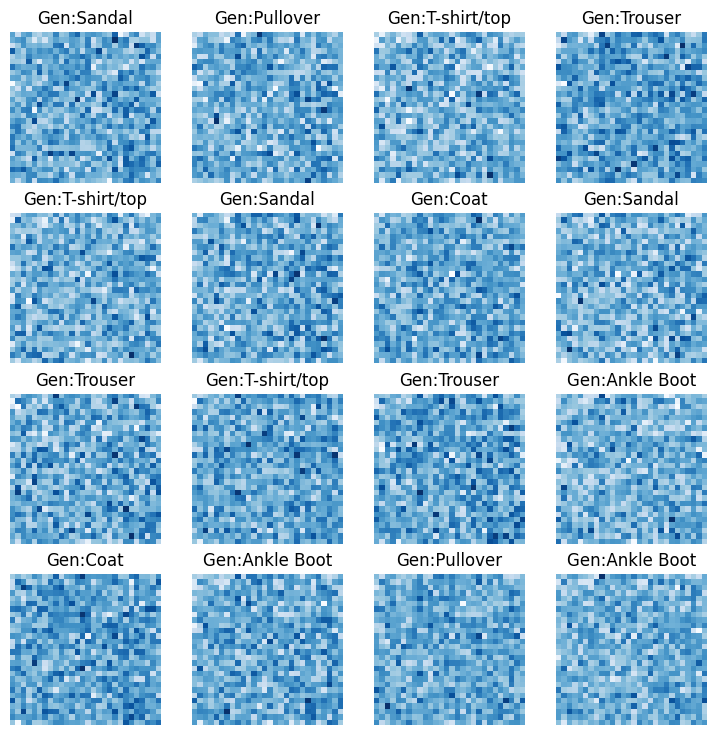

In [ ]:
gen_images = generator(fixed_noise, fixed_classes.to(DEVICE))
plot_gen_images(gen_images, fixed_classes)

### GAN condition обучение

In [ ]:
from torch import autograd

def compute_gradient_penalty(critic, real_samples, fake_samples, label):
    Tensor = torch.cuda.FloatTensor
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1)))

    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates, label)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1)) ** 2 -1).mean()
    return gradient_penalty

Epoch:1 Iter: 500 errD_x: 0.09 errD_z: 0.04 g_penalty: -7.01 errG: 3.87
Epoch:1 Iter: 1000 errD_x: 0.01 errD_z: 0.01 g_penalty: -8.55 errG: 5.12
Epoch:1 Iter: 1500 errD_x: 0.02 errD_z: 0.02 g_penalty: -6.35 errG: 5.05
Epoch:1 Iter: 2000 errD_x: 0.01 errD_z: 0.09 g_penalty: -3.09 errG: 3.72
Epoch:1 Iter: 2500 errD_x: 0.18 errD_z: 0.04 g_penalty: 12.09 errG: 3.94
Epoch:1 Iter: 3000 errD_x: 0.53 errD_z: 0.05 g_penalty: -1.26 errG: 3.83
Epoch:1 Iter: 3500 errD_x: 0.28 errD_z: 0.06 g_penalty: 12.32 errG: 3.55


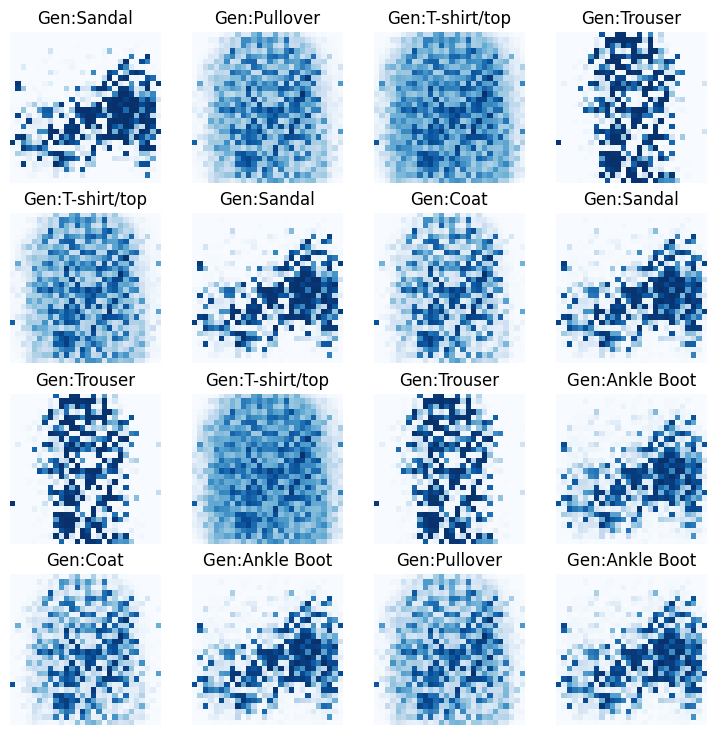

Epoch:2 Iter: 500 errD_x: 0.10 errD_z: 0.06 g_penalty: 10.13 errG: 3.95
Epoch:2 Iter: 1000 errD_x: 0.01 errD_z: 0.11 g_penalty: 31.29 errG: 3.48
Epoch:2 Iter: 1500 errD_x: 0.31 errD_z: 0.04 g_penalty: 23.68 errG: 3.79
Epoch:2 Iter: 2000 errD_x: 0.25 errD_z: 0.01 g_penalty: 25.42 errG: 5.03
Epoch:2 Iter: 2500 errD_x: 0.16 errD_z: 0.07 g_penalty: 17.80 errG: 3.23
Epoch:2 Iter: 3000 errD_x: 0.08 errD_z: 0.05 g_penalty: 24.84 errG: 3.89
Epoch:2 Iter: 3500 errD_x: 0.25 errD_z: 0.02 g_penalty: 15.46 errG: 4.23


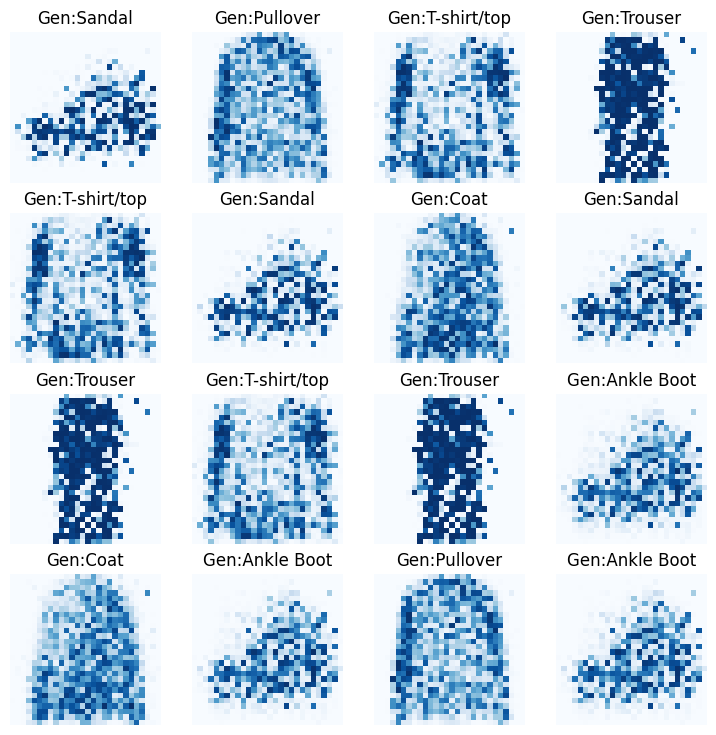

Epoch:3 Iter: 500 errD_x: 0.01 errD_z: 0.13 g_penalty: 19.23 errG: 3.37
Epoch:3 Iter: 1000 errD_x: 0.20 errD_z: 0.12 g_penalty: 55.48 errG: 2.50
Epoch:3 Iter: 1500 errD_x: 0.37 errD_z: 0.10 g_penalty: 39.29 errG: 3.32
Epoch:3 Iter: 2000 errD_x: 0.03 errD_z: 0.09 g_penalty: 51.41 errG: 3.72
Epoch:3 Iter: 2500 errD_x: 0.30 errD_z: 0.04 g_penalty: 44.73 errG: 4.56
Epoch:3 Iter: 3000 errD_x: 0.02 errD_z: 0.25 g_penalty: 65.34 errG: 2.66
Epoch:3 Iter: 3500 errD_x: 0.50 errD_z: 0.05 g_penalty: 104.75 errG: 3.60


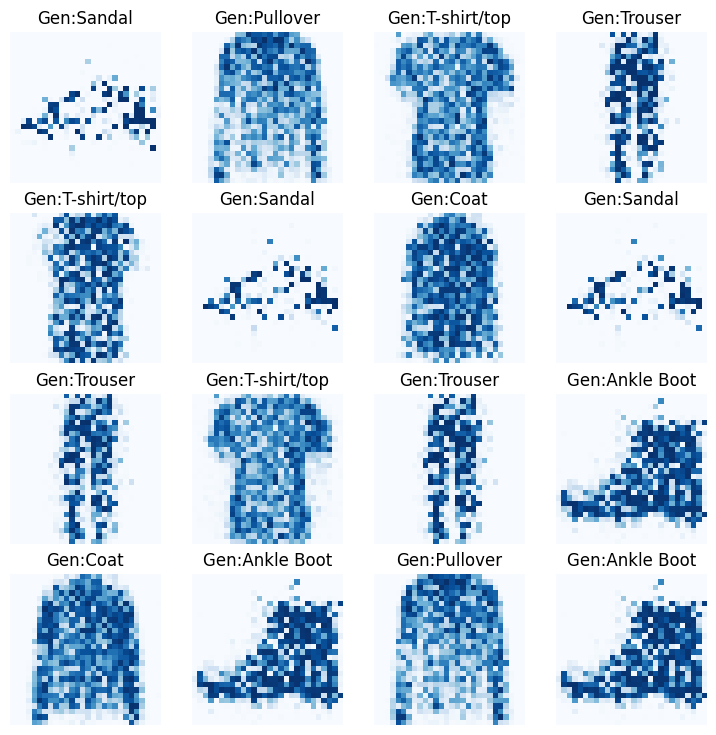

Epoch:4 Iter: 500 errD_x: 0.03 errD_z: 0.19 g_penalty: 27.09 errG: 3.37
Epoch:4 Iter: 1000 errD_x: 0.09 errD_z: 0.09 g_penalty: 71.08 errG: 3.59
Epoch:4 Iter: 1500 errD_x: 0.53 errD_z: 0.01 g_penalty: 45.97 errG: 4.50
Epoch:4 Iter: 2000 errD_x: 0.01 errD_z: 0.20 g_penalty: 44.95 errG: 2.61
Epoch:4 Iter: 2500 errD_x: 0.03 errD_z: 0.12 g_penalty: 101.91 errG: 3.12
Epoch:4 Iter: 3000 errD_x: 0.12 errD_z: 0.20 g_penalty: 60.48 errG: 3.79
Epoch:4 Iter: 3500 errD_x: 0.37 errD_z: 0.01 g_penalty: 61.91 errG: 5.01


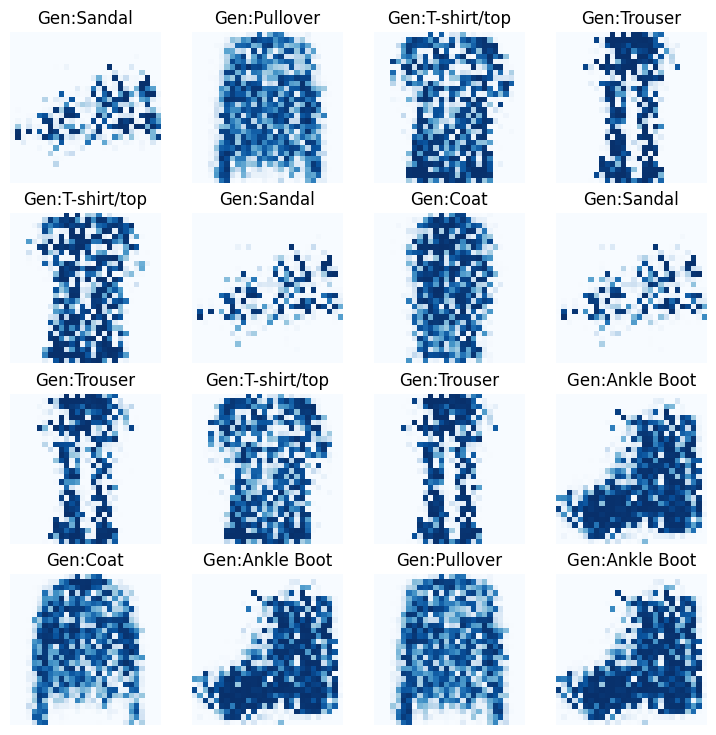

Epoch:5 Iter: 500 errD_x: 0.04 errD_z: 0.15 g_penalty: 112.46 errG: 4.24
Epoch:5 Iter: 1000 errD_x: 0.20 errD_z: 0.54 g_penalty: 138.95 errG: 1.92
Epoch:5 Iter: 1500 errD_x: 0.06 errD_z: 0.21 g_penalty: 97.43 errG: 2.58
Epoch:5 Iter: 2000 errD_x: 0.25 errD_z: 0.04 g_penalty: 115.49 errG: 4.37
Epoch:5 Iter: 2500 errD_x: 0.16 errD_z: 0.08 g_penalty: 103.81 errG: 3.47
Epoch:5 Iter: 3000 errD_x: 0.21 errD_z: 0.07 g_penalty: 110.00 errG: 4.10
Epoch:5 Iter: 3500 errD_x: 0.02 errD_z: 0.05 g_penalty: 65.26 errG: 3.39


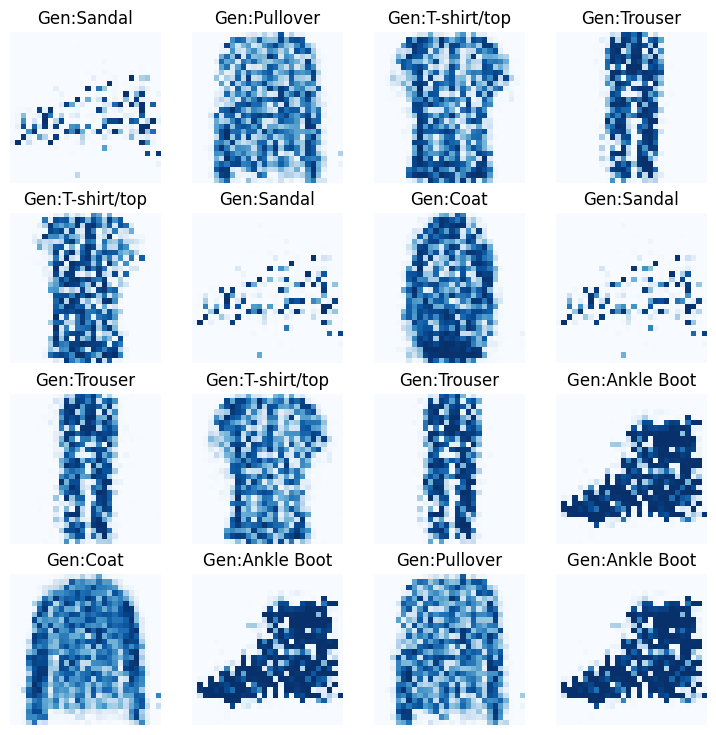

Epoch:6 Iter: 500 errD_x: 0.02 errD_z: 0.35 g_penalty: 71.92 errG: 3.05
Epoch:6 Iter: 1000 errD_x: 0.61 errD_z: 0.20 g_penalty: 94.95 errG: 2.82
Epoch:6 Iter: 1500 errD_x: 0.51 errD_z: 0.08 g_penalty: 147.93 errG: 2.94
Epoch:6 Iter: 2000 errD_x: 1.02 errD_z: 0.18 g_penalty: 97.02 errG: 2.60
Epoch:6 Iter: 2500 errD_x: 0.31 errD_z: 0.13 g_penalty: 154.63 errG: 2.34
Epoch:6 Iter: 3000 errD_x: 0.16 errD_z: 0.08 g_penalty: 62.97 errG: 3.18
Epoch:6 Iter: 3500 errD_x: 0.18 errD_z: 0.08 g_penalty: 144.38 errG: 3.58


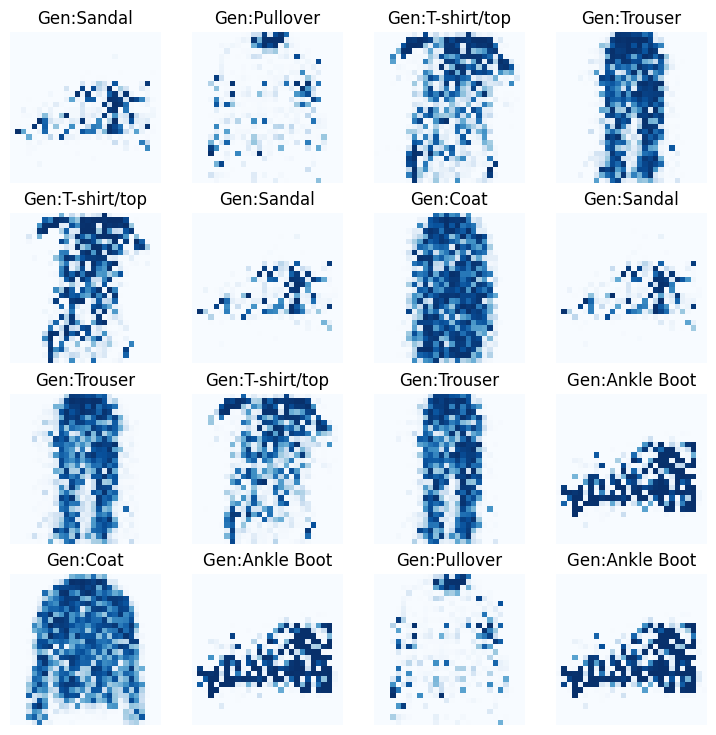

Epoch:7 Iter: 500 errD_x: 0.00 errD_z: 0.27 g_penalty: 42.83 errG: 2.30
Epoch:7 Iter: 1000 errD_x: 0.15 errD_z: 0.01 g_penalty: 89.12 errG: 5.32
Epoch:7 Iter: 1500 errD_x: 0.19 errD_z: 0.11 g_penalty: 78.97 errG: 3.88
Epoch:7 Iter: 2000 errD_x: 0.49 errD_z: 0.08 g_penalty: 149.67 errG: 5.74
Epoch:7 Iter: 2500 errD_x: 0.03 errD_z: 0.21 g_penalty: 89.62 errG: 2.85
Epoch:7 Iter: 3000 errD_x: 0.18 errD_z: 0.39 g_penalty: 160.72 errG: 2.94
Epoch:7 Iter: 3500 errD_x: 0.15 errD_z: 0.55 g_penalty: 111.53 errG: 3.28


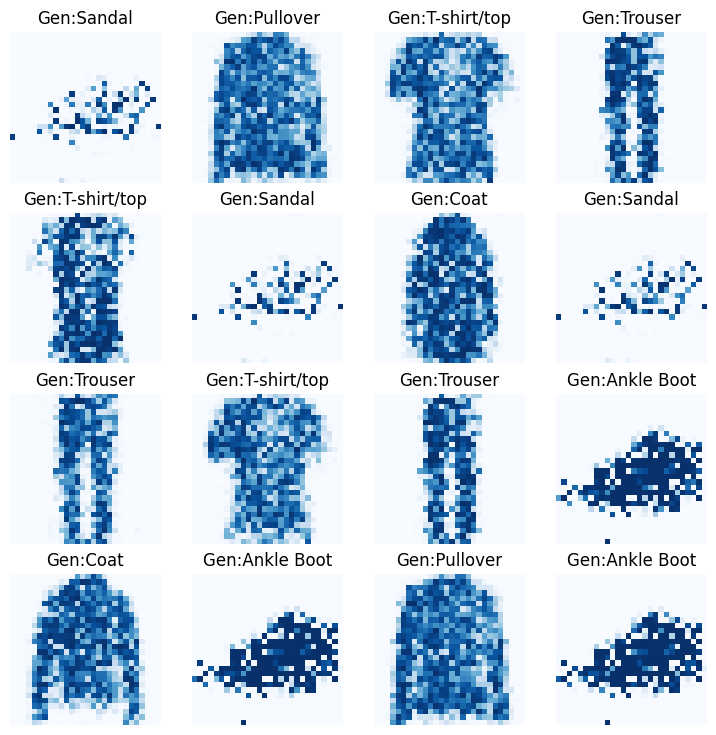

Epoch:8 Iter: 500 errD_x: 0.08 errD_z: 0.09 g_penalty: 55.66 errG: 4.56
Epoch:8 Iter: 1000 errD_x: 0.34 errD_z: 0.38 g_penalty: 141.68 errG: 2.98
Epoch:8 Iter: 1500 errD_x: 0.18 errD_z: 0.43 g_penalty: 76.56 errG: 2.62
Epoch:8 Iter: 2000 errD_x: 0.30 errD_z: 0.04 g_penalty: 99.08 errG: 4.30
Epoch:8 Iter: 2500 errD_x: 0.09 errD_z: 0.06 g_penalty: 100.95 errG: 3.30
Epoch:8 Iter: 3000 errD_x: 0.14 errD_z: 0.09 g_penalty: 113.55 errG: 3.37
Epoch:8 Iter: 3500 errD_x: 0.04 errD_z: 0.38 g_penalty: 131.84 errG: 2.19


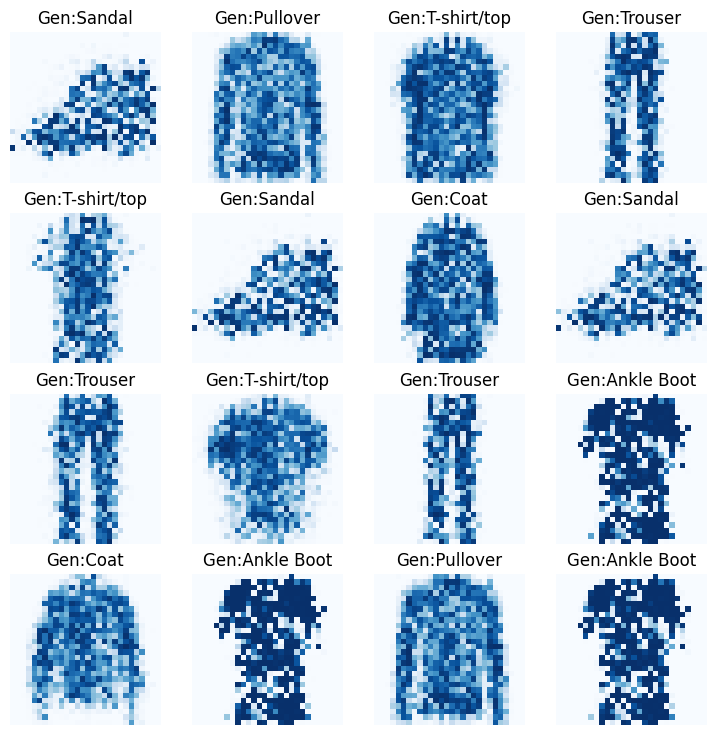

Epoch:9 Iter: 500 errD_x: 0.08 errD_z: 0.21 g_penalty: 83.86 errG: 4.21
Epoch:9 Iter: 1000 errD_x: 0.11 errD_z: 0.10 g_penalty: 98.47 errG: 3.47
Epoch:9 Iter: 1500 errD_x: 0.34 errD_z: 0.28 g_penalty: 152.77 errG: 2.09
Epoch:9 Iter: 2000 errD_x: 0.30 errD_z: 0.10 g_penalty: 66.23 errG: 4.46
Epoch:9 Iter: 2500 errD_x: 0.05 errD_z: 0.14 g_penalty: 41.12 errG: 4.34
Epoch:9 Iter: 3000 errD_x: 0.13 errD_z: 0.14 g_penalty: 139.61 errG: 2.96
Epoch:9 Iter: 3500 errD_x: 0.07 errD_z: 0.08 g_penalty: 45.01 errG: 3.58


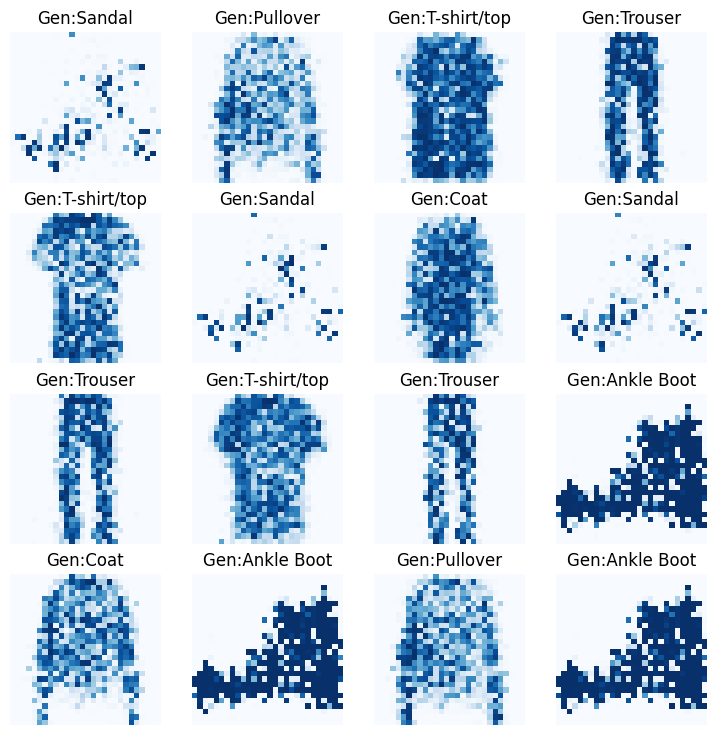

Epoch:10 Iter: 500 errD_x: 0.72 errD_z: 0.06 g_penalty: 24.32 errG: 3.76
Epoch:10 Iter: 1000 errD_x: 0.75 errD_z: 0.15 g_penalty: 47.33 errG: 2.62
Epoch:10 Iter: 1500 errD_x: 0.42 errD_z: 0.14 g_penalty: 97.47 errG: 2.55
Epoch:10 Iter: 2000 errD_x: 0.08 errD_z: 0.16 g_penalty: 75.28 errG: 3.08
Epoch:10 Iter: 2500 errD_x: 0.25 errD_z: 0.14 g_penalty: 133.07 errG: 3.55
Epoch:10 Iter: 3000 errD_x: 0.79 errD_z: 0.10 g_penalty: 185.76 errG: 3.37
Epoch:10 Iter: 3500 errD_x: 0.27 errD_z: 0.09 g_penalty: 120.58 errG: 4.42


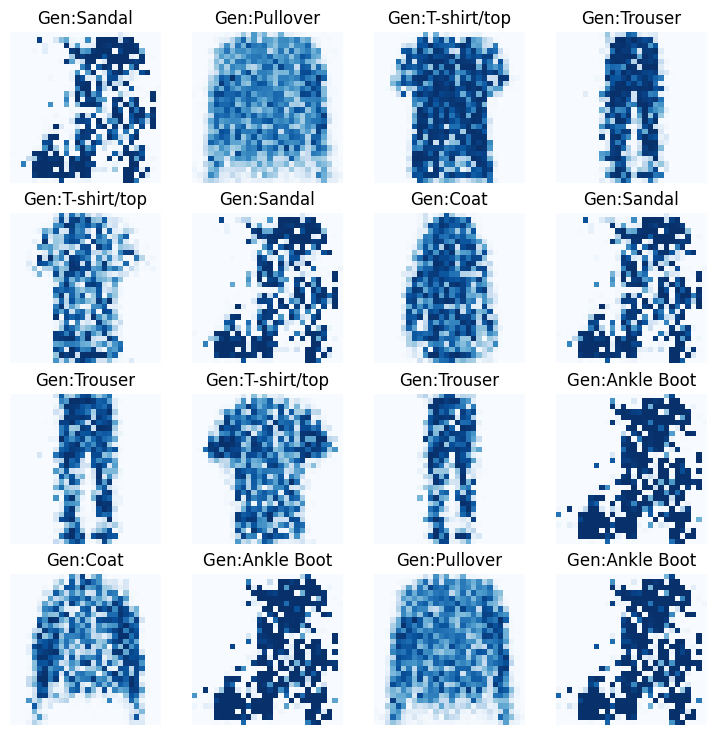

Epoch:11 Iter: 500 errD_x: 0.27 errD_z: 0.19 g_penalty: 73.85 errG: 2.71
Epoch:11 Iter: 1000 errD_x: 0.11 errD_z: 0.19 g_penalty: 195.15 errG: 2.49
Epoch:11 Iter: 1500 errD_x: 0.31 errD_z: 0.16 g_penalty: 134.54 errG: 3.00
Epoch:11 Iter: 2000 errD_x: 0.30 errD_z: 0.13 g_penalty: 108.85 errG: 2.70
Epoch:11 Iter: 2500 errD_x: 0.31 errD_z: 0.10 g_penalty: 93.87 errG: 3.05
Epoch:11 Iter: 3000 errD_x: 0.66 errD_z: 0.11 g_penalty: 95.45 errG: 3.52
Epoch:11 Iter: 3500 errD_x: 0.21 errD_z: 0.11 g_penalty: 143.20 errG: 3.30


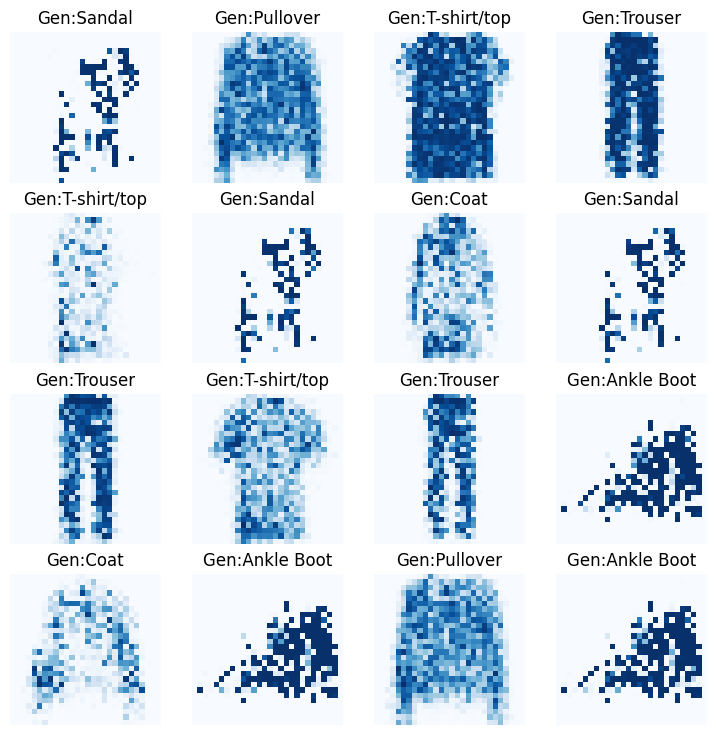

Epoch:12 Iter: 500 errD_x: 0.46 errD_z: 0.27 g_penalty: 45.03 errG: 3.01
Epoch:12 Iter: 1000 errD_x: 0.43 errD_z: 0.31 g_penalty: 157.37 errG: 2.88
Epoch:12 Iter: 1500 errD_x: 0.33 errD_z: 0.19 g_penalty: 75.24 errG: 3.47
Epoch:12 Iter: 2000 errD_x: 0.33 errD_z: 0.18 g_penalty: 41.48 errG: 2.45
Epoch:12 Iter: 2500 errD_x: 0.28 errD_z: 0.16 g_penalty: 109.86 errG: 2.86
Epoch:12 Iter: 3000 errD_x: 0.17 errD_z: 0.09 g_penalty: 138.44 errG: 3.63
Epoch:12 Iter: 3500 errD_x: 0.38 errD_z: 0.12 g_penalty: 172.20 errG: 3.96


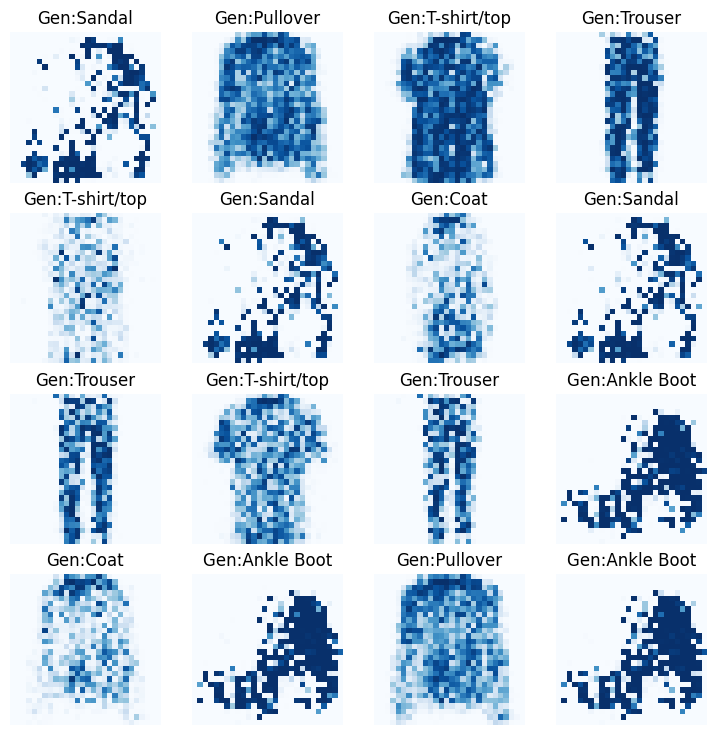

Epoch:13 Iter: 500 errD_x: 0.60 errD_z: 0.10 g_penalty: 167.69 errG: 3.98
Epoch:13 Iter: 1000 errD_x: 0.32 errD_z: 0.28 g_penalty: 166.24 errG: 3.09
Epoch:13 Iter: 1500 errD_x: 0.11 errD_z: 0.32 g_penalty: 138.34 errG: 2.66
Epoch:13 Iter: 2000 errD_x: 0.29 errD_z: 0.34 g_penalty: 490.75 errG: 3.01
Epoch:13 Iter: 2500 errD_x: 0.43 errD_z: 0.26 g_penalty: 220.96 errG: 2.92
Epoch:13 Iter: 3000 errD_x: 0.16 errD_z: 0.09 g_penalty: 188.14 errG: 3.60
Epoch:13 Iter: 3500 errD_x: 0.30 errD_z: 0.21 g_penalty: 157.07 errG: 2.88


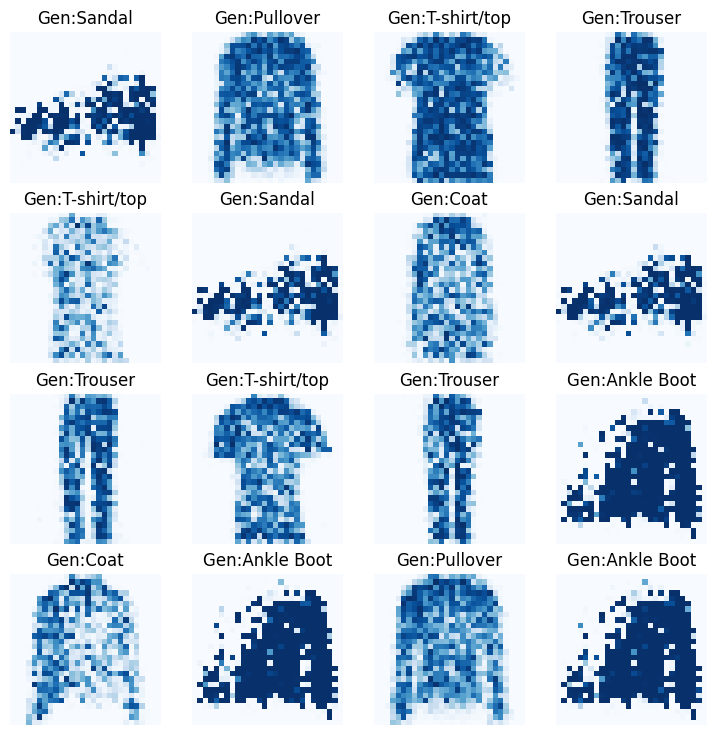

Epoch:14 Iter: 500 errD_x: 0.39 errD_z: 0.19 g_penalty: 106.44 errG: 2.91
Epoch:14 Iter: 1000 errD_x: 0.21 errD_z: 0.20 g_penalty: 161.62 errG: 2.72
Epoch:14 Iter: 1500 errD_x: 0.84 errD_z: 0.10 g_penalty: 183.92 errG: 3.11
Epoch:14 Iter: 2000 errD_x: 1.06 errD_z: 0.31 g_penalty: 143.29 errG: 3.68
Epoch:14 Iter: 2500 errD_x: 0.29 errD_z: 0.31 g_penalty: 269.23 errG: 2.36
Epoch:14 Iter: 3000 errD_x: 0.26 errD_z: 0.22 g_penalty: 283.34 errG: 3.28
Epoch:14 Iter: 3500 errD_x: 0.08 errD_z: 0.18 g_penalty: 68.28 errG: 4.03


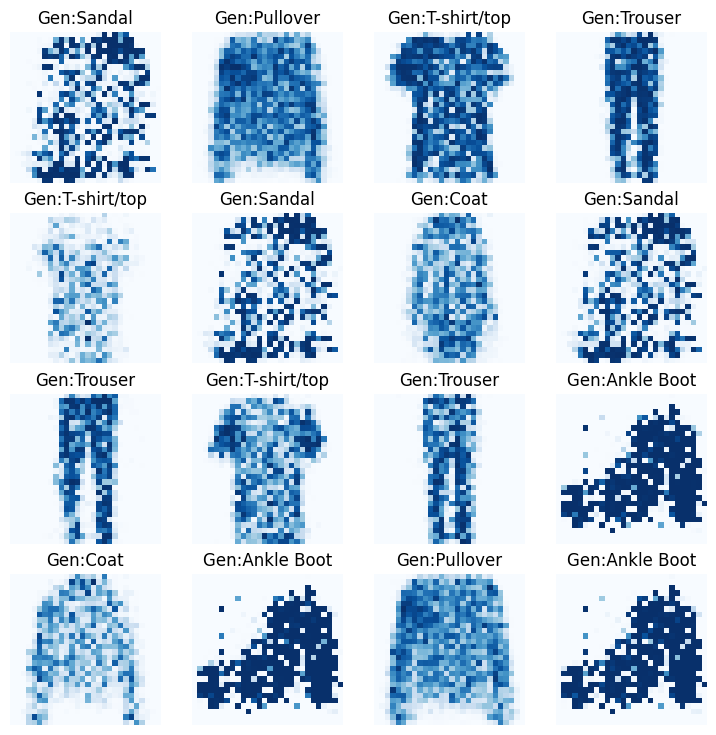

Epoch:15 Iter: 500 errD_x: 0.29 errD_z: 0.28 g_penalty: 172.51 errG: 3.03
Epoch:15 Iter: 1000 errD_x: 0.19 errD_z: 0.12 g_penalty: 135.48 errG: 3.17
Epoch:15 Iter: 1500 errD_x: 0.20 errD_z: 0.22 g_penalty: 119.91 errG: 2.67
Epoch:15 Iter: 2000 errD_x: 0.43 errD_z: 0.13 g_penalty: 154.94 errG: 2.98
Epoch:15 Iter: 2500 errD_x: 0.78 errD_z: 0.10 g_penalty: 142.31 errG: 2.69
Epoch:15 Iter: 3000 errD_x: 0.13 errD_z: 0.35 g_penalty: 121.07 errG: 2.25
Epoch:15 Iter: 3500 errD_x: 0.53 errD_z: 0.14 g_penalty: 147.80 errG: 2.82


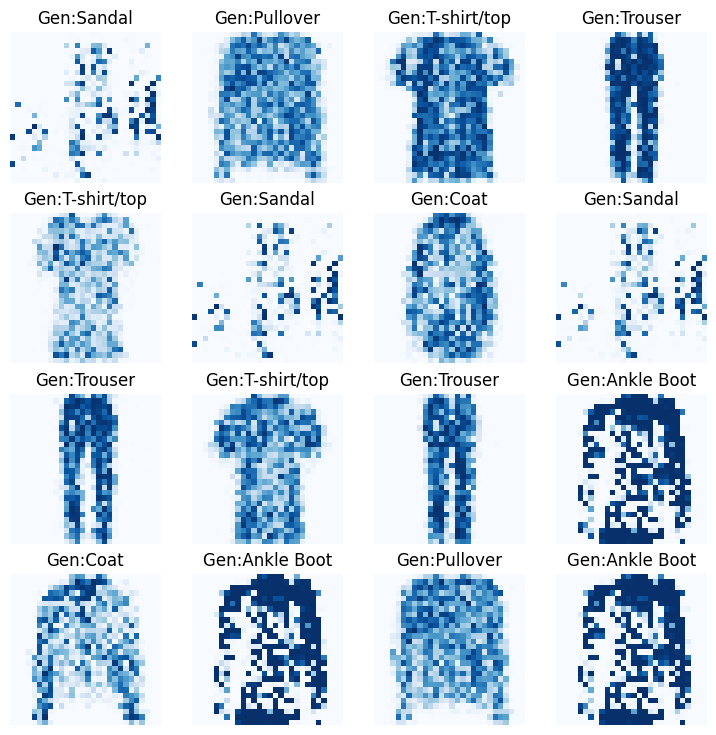

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRD_p = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)


# Loss weight for gradient penalty
lambda_gp = 10

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        optim_D.zero_grad()

        cls_images =  cat.to(DEVICE)

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(DEVICE)
        output = discriminator(input_data, cls_images).view(-1)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise, cls_images)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach(), cls_images).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()

        errD_z.backward()
        optim_D.step()


        # Gradient penalty
        gradient_penalty = lambda_gp * compute_gradient_penalty(discriminator,
                                                                input_data,
                                                                fake,
                                                                cls_images
                                                                )
        ERRD_p[epoch] += gradient_penalty.item()/config.batch_size

        gradient_penalty.backward(retain_graph=True)


        #######
        # Generator stage: maximize log(D(G(x))
        #######

        optim_G.zero_grad()

        label.data.fill_(real_label)
        output = discriminator(fake, cls_images).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()/config.batch_size

        errG.backward()
        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} g_penalty: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            gradient_penalty.item(),
                                                                                            errG.item()
                                                                                            )
            )


        # Show result with fix_noise
        gen_images = generator(fixed_noise, fixed_classes.to(DEVICE))
        if iteration == N-1: plot_gen_images(gen_images, fixed_classes)

<ipython-input-17-c380134cdd7f>:6: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ERRD_p),label="D_p")


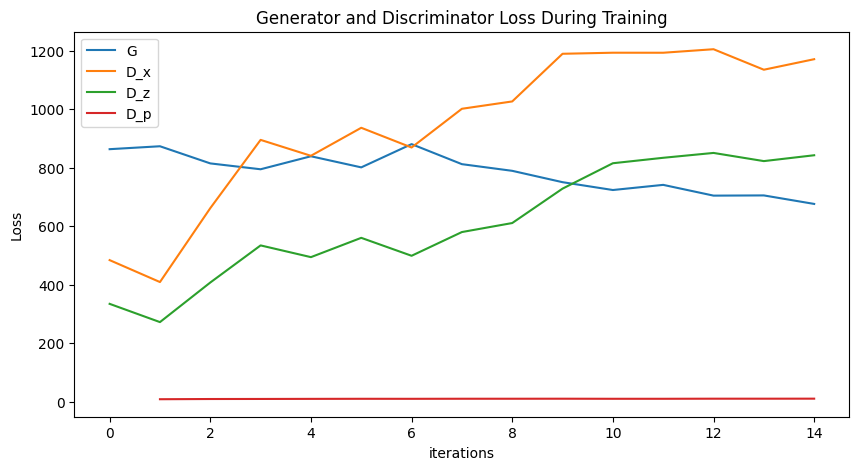

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(ERRG,label="G")
plt.plot(ERRD_x,label="D_x")
plt.plot(ERRD_z,label="D_z")
plt.plot(np.log(ERRD_p),label="D_p")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Комментарий

Условная генерация работает, стало появляться разнообразие в генерации.

Самое сложнон - это сандали, они более прозрачные. И модель сильно путается.

Возможно чего-то можно добиться еще изменениями модели....

Но лучше попробуем конволюционный генератор